# Réseaux de neurones : Echo State Network

## Une brève introduction

Les premières modélisations informatiques de neurones et de réseaux datent des années 1940. Appliquées à l'intelligence artificielle, les réseaux de neurones ont permis, notamment grâce à l'introduction du <b>perceptron</b>, de permettre à la machine d'"apprendre" par elle-même.

In [11]:
%matplotlib inline

## Importation des modules

In [25]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas LukoÅ¡eviÄ?ius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""
#from numpy import *
import numpy as np
#from matplotlib.pyplot import *
import matplotlib.pyplot as plt
#import scipy.linalg
from scipy import linalg
#from numpy import linalg
from ipywidgets import widgets

## Remise à zéro de l'aléatoire

In [26]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    # Set the seed
    if seed is None:
        import time
        seed = int((time.time()*10**6) % 10**12)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

## Création d'une classe "Réseau"

In [30]:
class Network(object):

    def __init__(self) :
        self.trainLen = 2000
        self.testLen = 2000
        self.initLen = 100
        self.data = np.loadtxt("MackeyGlass_t17.txt")

nw = Network()

## Affichage dynamique d'un échantillon de données

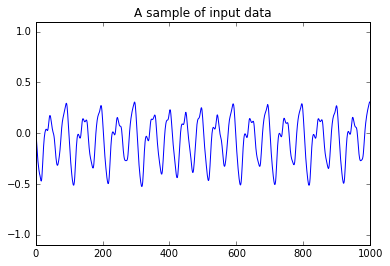

In [37]:
# plot some of it
def plot_figure(f) :
    plt.figure(0).clear()
    plt.plot(nw.data[0:f])
    plt.ylim([-1.1,1.1])
    plt.title('A sample of input data')
    plt.show()
    
interact(plot_figure, f=(1000,10000,1000))

## Variables

In [38]:
# generate the ESN reservoir
nw.inSize = nw.outSize = 1 #input/output dimension
nw.resSize = 300 #reservoir size (for prediction)
#resSize = 1000 #reservoir size (for generation)
a = 0.3 # leaking rate #A MODIFIER
spectral_radius = 1.25 #A MODIFIER
input_scaling = 1. #A MODIFIER
nw.reg =  1e-8 #None # regularization coefficient, if None, pseudo-inverse
#is use instead of ridge regression

mode = 'prediction'
#mode = 'generative'

#change the seed, reservoir performances should be averaged accross
#at least 20 random instances (with the same set of parameters)
seed = None #42

set_seed(seed) #random.seed(seed) 

!!! WARNING !!!: Seed was not set correctly.


218088554403

## Fonctions de traçages des courbes

In [50]:
# plot some signals
def plot_figure1(nw, mode) :
    plt.figure(1).clear()
    plt.plot( nw.data[nw.trainLen+1:nw.trainLen+nw.testLen+1], 'g' )
    plt.plot( nw.Y.T, 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])

def plot_figure2(a, spectral_radius, input_scaling) :
    nw = calcul_reseau(a, spectral_radius, input_scaling)
    plt.figure(2).clear()
    #plot( X[0:20,0:200].T )
    plt.plot( nw.X[0:2,0:2000].T ) #xav
    plt.legend(["biais", "input"])
    plt.ylim([-1.1,1.1])
    plt.title('Input $\mathbf{u}(n)$ and bias for 2000 time steps')

def plot_figure3(a, spectral_radius, input_scaling) :
    nw = calcul_reseau(a, spectral_radius, input_scaling)
    plt.figure(3).clear()
    plt.plot( nw.X[2:12,0:200].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to 9 for 200 time steps')

def plot_figure4(a, spectral_radius, input_scaling) :
    nw = calcul_reseau(a, spectral_radius, input_scaling)
    plt.figure(4).clear()
    plt.plot( nw.X[2:12,:].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to 9 for all time steps')

def plot_figure5(a, spectral_radius, input_scaling) :
    nw = calcul_reseau(a, spectral_radius, input_scaling)
    plt.figure(5).clear()
    plt.plot( nw.X[2:,0:200].T )
    plt.ylim([-1.1,1.1])
    plt.title('All reservoir activations $\mathbf{x}(n)$ for 200 time steps')

def plot_figure6(a, spectral_radius, input_scaling) :
    nw = calcul_reseau(a, spectral_radius, input_scaling)
    plt.figure(6).clear()
    plt.bar( range(1+nw.inSize+nw.resSize), nw.Wout.T )
    plt.title('Output weights $\mathbf{W}^{out}$')

## Calcul du réseau en fonction des paramètres

In [67]:
def calcul_reseau(a, spectral_radius, input_scaling) :

    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    # Option 1 - direct scaling (quick&dirty, reservoir-specific):
    #W *= 0.135 
    # Option 2 - normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...',)
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    #np_rhoW = max(abs(np.linalg.eig(W)[0]))
    #print("Difference between scipy and numpy .eig() method: scipy="+str(rhoW)+" numpy="+str(np_rhoW)
    print('done.')
    nw.W *= spectral_radius / rhoW
    
    # allocated memory for the design (collected states) matrix
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    # set the corresponding target matrix directly
    nw.Yt = nw.data[None,nw.initLen+1:nw.trainLen+1]

    # run the reservoir with the data and collect X
    nw.x = np.zeros((nw.resSize,1))

    for t in range(nw.trainLen):
        nw.u = nw.data[t]
        nw.x = (1-a)*nw.x + a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot( nw.W, nw.x ) )
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u,nw.x))[:,0]
    print("a :", a, "- spectral radius :", spectral_radius, "- input scaling :", input_scaling)

    # train the output
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # use ridge regression (linear regression with regularization)
        nw.Wout = np.dot(np.dot(nw.Yt,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
        ### Just if you want to try the difference between scipy.linalg and numpy.linalg which does not give the same results
            ### For more info, see https://www.scipy.org/scipylib/faq.html#why-both-numpy-linalg-and-scipy-linalg-what-s-the-difference
    #    np_Wout = np.dot(np.dot(Yt,X_T), np.linalg.inv(np.dot(X,X_T) + \
    #        reg*np.eye(1+inSize+resSize) ) )
    #    print("Difference between scipy and numpy .inv() method:\n\tscipy_mean_Wout="+\
    #        str(np.mean(Wout))+"\n\tnumpy_mean_Wout="+str(np.mean(np_Wout))
    else:
        # use pseudo inverse
        nw.Wout = np.dot(nw.Yt, linalg.pinv(nw.X) )

    # run the trained ESN in a generative mode. no need to initialize here, 
    # because x is initialized with training data and we continue from there.
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-a)*nw.x + a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u,nw.x)) )
        nw.Y[:,t] = nw.y
        if mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif mode == 'prediction':
            ## predictive mode:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")

    # compute MSE for the first errorLen time steps
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

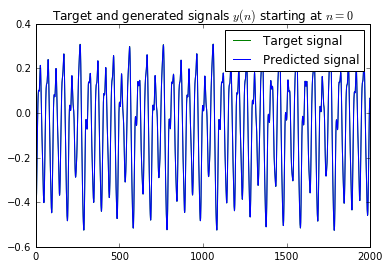

In [68]:
plot_figure1(nw, mode)

Computing spectral radius...
done.
a : 0.5 - spectral radius : 0.9500000000000001 - input scaling : 0.9500000000000001
MSE = 1.78457135077e-08


<function __main__.plot_figure2>

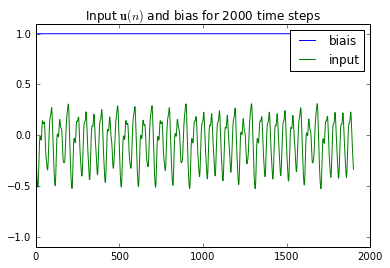

In [69]:
#plot_figure2(a, spectral_radius, input_scaling)
interact(plot_figure2, a=(0.05,1.0,0.05), spectral_radius=(0.5,1.5,0.05), input_scaling=(0.5,1.5,0.05))

Computing spectral radius...
done.
a : 0.5 - spectral radius : 0.9500000000000001 - input scaling : 0.9500000000000001
MSE = 2.17604656953e-08


<function __main__.plot_figure3>

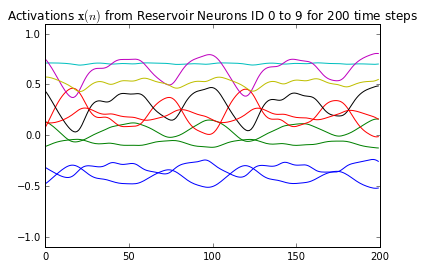

In [70]:
interact(plot_figure3, a=(0.05,1.0,0.05), spectral_radius=(0.5,1.5,0.05), input_scaling=(0.5,1.5,0.05))

Computing spectral radius...
done.
a : 0.5 - spectral radius : 0.9500000000000001 - input scaling : 0.9500000000000001
MSE = 1.75580406616e-08


<function __main__.plot_figure4>

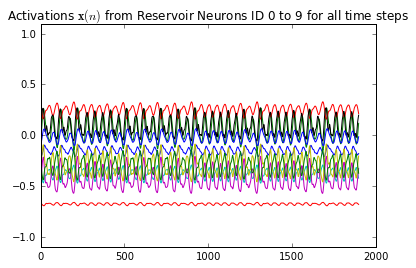

In [71]:
interact(plot_figure4, a=(0.05,1.0,0.05), spectral_radius=(0.5,1.5,0.05), input_scaling=(0.5,1.5,0.05))

In [74]:
interact(plot_figure5, a=(0.05,1.0,0.05), spectral_radius=(0.5,1.5,0.05), input_scaling=(0.5,1.5,0.05))

Computing spectral radius...
done.


Computing spectral radius...
done.
a : 0.5 - spectral radius : 0.9500000000000001 - input scaling : 0.9500000000000001
MSE = 1.06848467539e-08


<function __main__.plot_figure6>

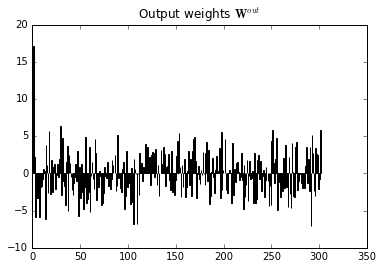

In [73]:
interact(plot_figure6, a=(0.05,1.0,0.05), spectral_radius=(0.5,1.5,0.05), input_scaling=(0.5,1.5,0.05))